<center><h1>Gradient Boosting</h1></center>

# 1. Information

https://archive.ics.uci.edu/ml/datasets/Yeast  
Predicted Attribute: Localization site of protein. ( non-numeric ).

The references below describe a predecessor to this dataset and its development. They also give results (not cross-validated) for classification by a rule-based expert system with that version of the dataset.

Reference: "Expert Sytem for Predicting Protein Localization Sites in Gram-Negative Bacteria", Kenta Nakai & Minoru Kanehisa, PROTEINS: Structure, Function, and Genetics 11:95-110, 1991.

Reference: "A Knowledge Base for Predicting Protein Localization Sites in Eukaryotic Cells", Kenta Nakai & Minoru Kanehisa, Genomics 14:897-911, 1992.


Attribute Information:

1. Sequence Name: Accession number for the SWISS-PROT database
2. mcg: McGeoch's method for signal sequence recognition.
3. gvh: von Heijne's method for signal sequence recognition.
4. alm: Score of the ALOM membrane spanning region prediction program.
5. mit: Score of discriminant analysis of the amino acid content of the N-terminal region (20 residues long) of mitochondrial and non-mitochondrial proteins.
6. erl: Presence of "HDEL" substring (thought to act as a signal for retention in the endoplasmic reticulum lumen). Binary attribute.
7. pox: Peroxisomal targeting signal in the C-terminus.
8. vac: Score of discriminant analysis of the amino acid content of vacuolar and extracellular proteins.
9. nuc: Score of discriminant analysis of nuclear localization signals of nuclear and non-nuclear proteins.

# 2. Fetching Data:

## 2.1 Import packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline
import warnings
import math
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

## 2.2 Import data

In [2]:
data=pd.read_csv("yeast.data", sep='\s+', na_values='None',
                 names=['ser_name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class'])

In [3]:
data.head(5)

,ser_name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [4]:
data.tail(5)

,ser_name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC
1483,G6PD_YEAST,0.65,0.54,0.54,0.13,0.5,0.0,0.53,0.22,CYT


# 3. Data Cleaning

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 10 columns):
ser_name    1484 non-null object
mcg         1484 non-null float64
gvh         1484 non-null float64
alm         1484 non-null float64
mit         1484 non-null float64
erl         1484 non-null float64
pox         1484 non-null float64
vac         1484 non-null float64
nuc         1484 non-null float64
class       1484 non-null object
dtypes: float64(8), object(2)
memory usage: 116.1+ KB


In [6]:
data['ser_name'].value_counts()

MAT2_YEAST    2
RLUB_YEAST    2
RL12_YEAST    2
MTC_YEAST     2
RL1A_YEAST    2
             ..
NDC1_YEAST    1
CACP_YEAST    1
RFT1_YEAST    1
CYP1_YEAST    1
INV4_YEAST    1
Name: ser_name, Length: 1462, dtype: int64

Судя по номеру доступа для базы данных SWISS-PROT (переменная *'ser_name'*), в датасете есть повторения.

In [7]:
data=data.drop_duplicates()

In [8]:
data['ser_name'].value_counts()

RLA4_YEAST    1
SAC7_YEAST    1
YB37_YEAST    1
COX9_YEAST    1
MS51_YEAST    1
             ..
MPP1_YEAST    1
MCM3_YEAST    1
ISP6_YEAST    1
RFC3_YEAST    1
INV4_YEAST    1
Name: ser_name, Length: 1462, dtype: int64

In [9]:
data=data.drop('ser_name', axis=1)

In [10]:
data.shape

(1462, 9)

# 4. EDA

## 4.1 Target variable *'class'*

In [11]:
data['class'].value_counts()

CYT    444
NUC    426
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: class, dtype: int64

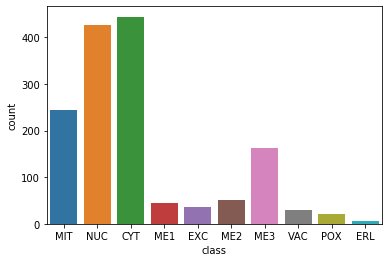

In [12]:
sns.countplot(x='class',data=data, orient='v')

## 4.2 Base statistics and distributions

In [13]:
data.describe(percentiles = [0.5, 0.25, 0.75, 0.95])

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000
mean,0.500534,0.500999,0.498564,0.260684,0.504788,0.007613,0.500855,0.277216
std,0.137581,0.124022,0.085332,0.136743,0.048710,0.076245,0.056412,0.106469
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.450000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
95%,0.770000,0.730000,0.620000,0.540000,0.500000,0.000000,0.570000,0.490000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BC981C8>,
      dtype=object)

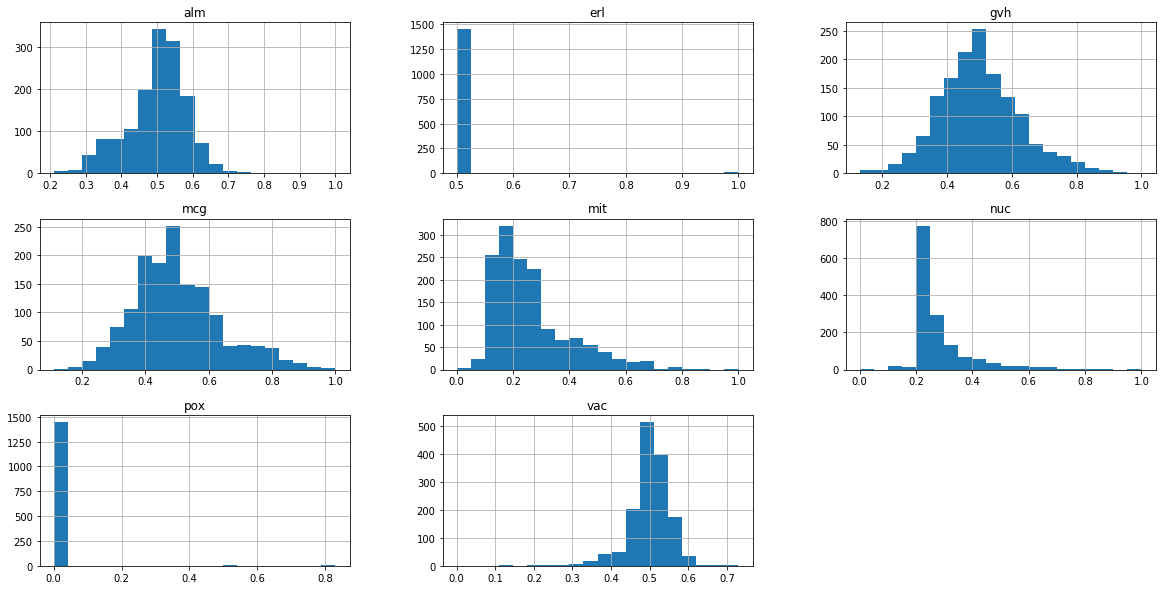

In [14]:
data.drop('class', axis=1).hist(figsize=(20,10), bins=20)

Большая часть переменных имеют распределения близкие к нормальному. Опасение вызываюут признаки *'pox'* и *'erl'*

## 4.3 Outlier processing

## 4.3.1 *'pox'* variable

In [15]:
data['pox'].value_counts()

0.00    1447
0.83      11
0.50       4
Name: pox, dtype: int64

In [16]:
data.loc[data['pox']==0.83]

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
84,0.67,0.62,0.40,0.43,0.5,0.83,0.50,0.22,MIT
175,0.44,0.38,0.48,0.32,0.5,0.83,0.53,0.22,POX
250,0.44,0.53,0.52,0.23,0.5,0.83,0.51,0.22,POX
319,0.69,0.60,0.51,0.13,0.5,0.83,0.52,0.22,POX
558,0.68,0.58,0.51,0.19,0.5,0.83,0.54,0.22,POX
592,0.42,0.50,0.53,0.22,0.5,0.83,0.50,0.22,POX
609,0.60,0.51,0.60,0.38,0.5,0.83,0.52,0.24,MIT
720,0.49,0.27,0.57,0.18,0.5,0.83,0.54,0.22,POX
1145,0.32,0.68,0.51,0.16,0.5,0.83,0.55,0.22,POX
1388,0.40,0.40,0.43,0.19,0.5,0.83,0.48,0.22,POX


In [17]:
data.loc[data['pox']==0.5]

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
5,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
110,0.45,0.41,0.50,0.46,0.5,0.5,0.50,0.27,POX
229,0.37,0.53,0.60,0.19,0.5,0.5,0.42,0.22,POX
759,0.48,0.52,0.49,0.35,0.5,0.5,0.51,0.22,MIT


Переменная *’pox’* - уникальный признак для класса *pox*, поскольку 12 представителей данного класса (из 20, входящих в данный датасет) имеют значения отличные от нуля. Поэтому выбросы из этой переменной убирать нельзя. 

## 4.3.2 *'erl'* variable

In [18]:
data['erl'].value_counts()

0.5    1448
1.0      14
Name: erl, dtype: int64

In [19]:
data.loc[data['erl']==1.0]

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
219,0.78,0.74,0.58,0.25,1.0,0.0,0.53,0.22,ERL
304,0.77,0.80,0.51,0.40,1.0,0.0,0.54,0.22,ERL
306,0.35,0.46,0.49,0.15,1.0,0.0,0.55,0.35,CYT
395,0.56,0.57,0.63,0.39,1.0,0.0,0.59,0.40,NUC
488,0.85,0.56,0.33,0.38,1.0,0.0,0.55,0.25,ERL
500,0.43,0.52,0.53,0.52,1.0,0.0,0.49,0.22,CYT
506,0.86,0.92,0.50,0.37,1.0,0.0,0.53,0.32,ERL
659,0.53,0.41,0.50,0.24,1.0,0.0,0.47,0.22,CYT
707,0.69,0.62,0.49,0.00,1.0,0.0,0.47,0.22,NUC
739,0.70,0.84,0.49,0.28,1.0,0.0,0.58,0.22,ERL


Переменная *’erl’* - уникальный признак для класса *erl*, поскольку 5 представителей данного класса (из 5, входящих в данный датасет) имеют значения отличные от 0.5. Поэтому выбросы из этой переменной убирать нельзя. 

## 4.4 Correlation analysis

(8.0, 0.0)

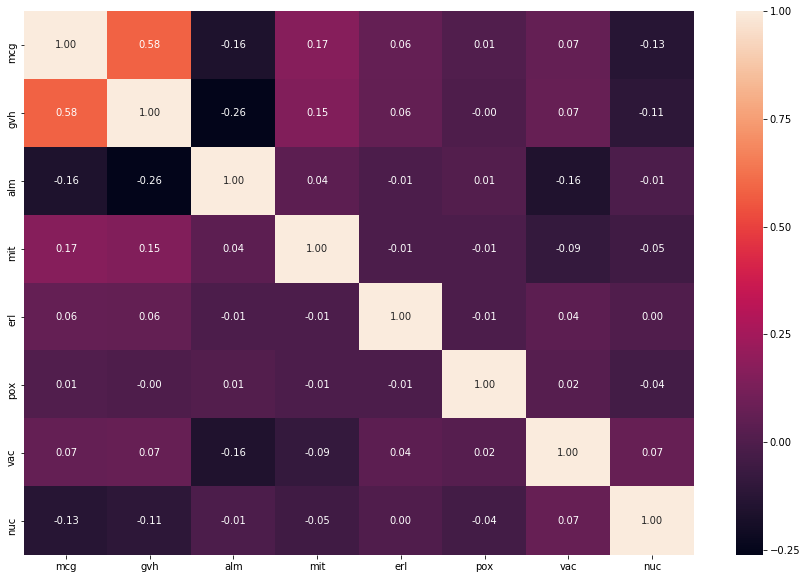

In [20]:
Corr =  data.dropna().corr()
plt.figure(figsize=(15,10));
ax=sns.heatmap(Corr, annot=True, fmt='.2f')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Сильной корреляции между признаками не наблюдается. Да и для нелинейной модели, такой как *Gradient Boost*, это не столь важно.

# 5 Machine learning 

## 5.1 Import packages

In [21]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

## 5.2 Quality Report function

In [22]:
def plot_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm)
    plt.figure(figsize = (5,5))
    ax=sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

## 5.3 Data Split and Scaling

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['class'], axis=1),
    data['class'], test_size=0.3,
    stratify=data['class'],
    random_state=42)

## 5.4 Oversampling initial data

In [24]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [25]:
X_train_sampled, y_train_sampled = SMOTE(k_neighbors=2).fit_sample(X_train, y_train)

## 5.5 Gradient Boosting Model

### 5.5.1 Initial Model

In [26]:
model_Gboost = GradientBoostingClassifier(   
                                            random_state = 42
                                          )
model_Gboost.fit(X_train_sampled, y_train_sampled)
pred_Gboost = model_Gboost.predict(X_test)

In [27]:
print(classification_report(pred_Gboost, y_test.values))

              precision    recall  f1-score   support

         CYT       0.59      0.53      0.56       148
         ERL       0.50      1.00      0.67         1
         EXC       0.45      0.36      0.40        14
         ME1       0.62      0.53      0.57        15
         ME2       0.60      0.43      0.50        21
         ME3       0.80      0.80      0.80        49
         MIT       0.56      0.59      0.57        70
         NUC       0.52      0.60      0.55       110
         POX       0.33      0.50      0.40         4
         VAC       0.00      0.00      0.00         7

    accuracy                           0.57       439
   macro avg       0.50      0.53      0.50       439
weighted avg       0.58      0.57      0.57       439



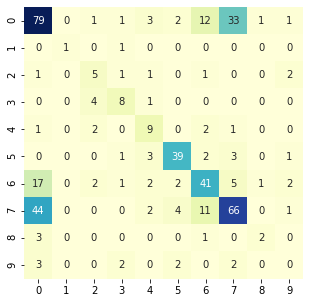

In [28]:
plot_confusion(y_test, pred_Gboost)

### 5.5.2 Grid search by parameters

In [34]:
param_grid = {
    'criterion'   : ['friedman_mse', 'mse', 'mae'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'subsample'   : np.logspace(-3, 0, 5)
}

#search = RandomizedSearchCV(model_Gboost, param_grid, n_jobs=-1, cv=5, random_state=42)
search = GridSearchCV(model_Gboost, param_grid, n_jobs=-1, cv=5)
search.fit(X_train_sampled, y_train_sampled)
search.best_params_

D:\AnacondaPy\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'friedman_mse', 'max_features': 'log2', 'subsample': 1.0}

In [37]:
pred_Gboost =search.best_estimator_.predict(X_test)
print(classification_report(pred_Gboost, y_test.values))

              precision    recall  f1-score   support

         CYT       0.59      0.55      0.57       143
         ERL       0.50      1.00      0.67         1
         EXC       0.55      0.40      0.46        15
         ME1       0.69      0.60      0.64        15
         ME2       0.60      0.41      0.49        22
         ME3       0.82      0.82      0.82        49
         MIT       0.60      0.59      0.60        74
         NUC       0.50      0.60      0.55       106
         POX       0.50      0.75      0.60         4
         VAC       0.00      0.00      0.00        10

    accuracy                           0.58       439
   macro avg       0.53      0.57      0.54       439
weighted avg       0.58      0.58      0.58       439



### 5.5.3 Model with Grid search results

In [38]:
model_Gboost = GradientBoostingClassifier(
                                            criterion    = 'friedman_mse', 
                                            max_features = 'log2',
                                            subsample    = 1.0,
                                            n_estimators = 101,
                                            random_state = 42
                                         )
model_Gboost.fit(X_train_sampled, y_train_sampled)
pred_Gboost = model_Gboost.predict(X_test)

In [39]:
print(classification_report(pred_Gboost, y_test.values))

              precision    recall  f1-score   support

         CYT       0.59      0.55      0.57       143
         ERL       0.50      1.00      0.67         1
         EXC       0.55      0.40      0.46        15
         ME1       0.69      0.60      0.64        15
         ME2       0.60      0.41      0.49        22
         ME3       0.82      0.82      0.82        49
         MIT       0.60      0.59      0.60        74
         NUC       0.50      0.60      0.55       106
         POX       0.50      0.75      0.60         4
         VAC       0.00      0.00      0.00        10

    accuracy                           0.58       439
   macro avg       0.53      0.57      0.54       439
weighted avg       0.58      0.58      0.58       439



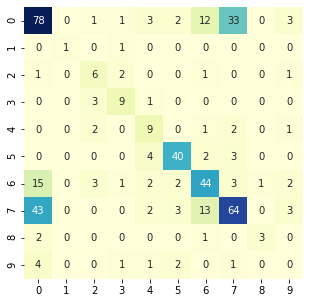

In [40]:
plot_confusion(y_test, pred_Gboost)

## 6 Conclusion

Оптимальными параметрами для Gradient Goost модели оказались: 
* criterion    = 'friedman_mse', 
* max_features = 'log2',
* subsample    = 1.0,
* n_estimators = 101.  

Градиентный бутинг отработал не очень хорошо. Это связано, главным образом, с большим количеством классов и их неравномерным представлением в выборке. Оверсемплинг немного помог.